Notebook by Jacqueline Lam

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

import random
import os

# import tensorflow as tf
import torch
from transformers import BertTokenizer, BertModel

from sklearn.model_selection import train_test_split

import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

##Load Data

In [ ]:
df = pd.read_parquet("hf://datasets/QuotaClimat/frugalaichallenge-text-train/train.parquet")
df.head(5)

,quote,label,source,url,language,subsource,id
0,"There is clear, compelling evidence that many ...",5_science_unreliable,FLICC,https://huggingface.co/datasets/fzanartu/FLICC...,en,CARDS,None
1,"For most of the Holocene (last 10k years), sea...",1_not_happening,FLICC,https://huggingface.co/datasets/fzanartu/FLICC...,en,hamburg_test1,None
2,"China, which hosts U.N. climate talks next wee...",4_solutions_harmful_unnecessary,FLICC,https://huggingface.co/datasets/fzanartu/FLICC...,en,CARDS,None
3,And the fabricated documents (which Dr. Mann a...,0_not_relevant,FLICC,https://huggingface.co/datasets/fzanartu/FLICC...,en,CARDS,None
4,It's going to be 42 here today and the hottest...,1_not_happening,FLICC,https://huggingface.co/datasets/fzanartu/FLICC...,en,hamburg_test3,None


In [ ]:
df = pd.read_pickle("/content/drive/My Drive/Jacq/data_vector.pkl")

In [ ]:
df.label.value_counts()

,count
label,
0_not_relevant,1618
5_science_unreliable,801
6_proponents_biased,782
4_solutions_harmful_unnecessary,774
1_not_happening,741
2_not_human,702
3_not_bad,386
7_fossil_fuels_needed,287


##Vectorize (Bert Embedding)

In [ ]:
# Set a random seed
random_seed = 123
random.seed(random_seed)

# Set a random seed for PyTorch (for GPU as well)
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(random_seed)

# Load BERT tokenizer and model
tokenizer_bert = BertTokenizer.from_pretrained('bert-base-uncased')
model_bert = BertModel.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
def bert_embedding(example_sentence, model=model_bert, tokenizer=tokenizer_bert):

  # Tokenize and encode the example sentence
  example_encoding = tokenizer.batch_encode_plus(
      [example_sentence],
      padding=True,
      truncation=True,
      return_tensors='pt',
      add_special_tokens=True
  )
  example_input_ids = example_encoding['input_ids']
  example_attention_mask = example_encoding['attention_mask']

  # Generate embeddings for the example sentence
  with torch.no_grad():
      example_outputs = model(example_input_ids, attention_mask=example_attention_mask)
      example_sentence_embedding = example_outputs.last_hidden_state.mean(dim=1).numpy()

  return example_sentence_embedding

In [ ]:
df['vector_bert'] = df['quote'].apply(bert_embedding)
df.head(5)

,quote,label,source,url,language,subsource,id,vector_bert
0,"There is clear, compelling evidence that many ...",5_science_unreliable,FLICC,https://huggingface.co/datasets/fzanartu/FLICC...,en,CARDS,None,"[[0.10070343, 0.09400773, 0.2060316, -0.193732..."
1,"For most of the Holocene (last 10k years), sea...",1_not_happening,FLICC,https://huggingface.co/datasets/fzanartu/FLICC...,en,hamburg_test1,None,"[[-0.27479276, 0.032737397, 0.7486866, -0.0202..."
2,"China, which hosts U.N. climate talks next wee...",4_solutions_harmful_unnecessary,FLICC,https://huggingface.co/datasets/fzanartu/FLICC...,en,CARDS,None,"[[-0.29666346, -0.04718276, 0.47567102, 0.2630..."
3,And the fabricated documents (which Dr. Mann a...,0_not_relevant,FLICC,https://huggingface.co/datasets/fzanartu/FLICC...,en,CARDS,None,"[[0.12714948, 0.384549, 0.24362367, 0.02624750..."
4,It's going to be 42 here today and the hottest...,1_not_happening,FLICC,https://huggingface.co/datasets/fzanartu/FLICC...,en,hamburg_test3,None,"[[-0.11301974, 0.09773082, 0.19773208, 0.00942..."


In [ ]:
df.to_pickle("/content/drive/My Drive/Jacq/data_vector.pkl")
os.listdir("/content/drive/My Drive/Jacq/")

['clustering.ipynb', 'data_vector.pkl']

##Train, Test Split

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=123)

train_df.shape, test_df.shape

((4872, 8), (1219, 8))

## Cosine Similarity (Embedding)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
def cosine_sim(a,b):
  similarity_score = cosine_similarity(a, b)[0][0]
  return similarity_score

##Model: centroid similarity

In [ ]:
c = train_df.groupby(['label'])['vector_bert'].mean().reset_index()
c.rename(columns={'label':'label_c', 'vector_bert':'vector_c'}, inplace=True)
c

,label_c,vector_c
0,0_not_relevant,"[[0.0010881092, 0.07108209, 0.09318381, 0.0236..."
1,1_not_happening,"[[-0.08107174, -0.03827519, 0.32127938, 0.0457..."
2,2_not_human,"[[-0.041563634, 0.117846854, 0.22749794, 0.089..."
3,3_not_bad,"[[-0.006956227, 0.097530015, 0.21664932, 0.125..."
4,4_solutions_harmful_unnecessary,"[[0.0030283728, 0.06567676, 0.186158, 0.167444..."
5,5_science_unreliable,"[[-0.043607518, 0.14278981, 0.17474753, 0.0665..."
6,6_proponents_biased,"[[0.09919138, 0.13349333, 0.11828236, 0.053209..."
7,7_fossil_fuels_needed,"[[0.03796603, 0.05595998, 0.12830777, 0.178209..."


In [ ]:
df2 = test_df.merge(c, how='cross')
df2['similarity'] = df2.apply(lambda x: cosine_sim(x['vector_bert'], x['vector_c']), axis=1)
df2.head()

,quote,label,source,url,language,subsource,id,vector_bert,label_c,vector_c,similarity
0,"I think there is man made climate change, I do...",5_science_unreliable,Desmog,https://www.desmog.com/rod-liddle/,en,None,None,"[[0.0660477, 0.09645033, 0.023849951, -0.02678...",0_not_relevant,"[[0.0010881092, 0.07108209, 0.09318381, 0.0236...",0.842697
1,"I think there is man made climate change, I do...",5_science_unreliable,Desmog,https://www.desmog.com/rod-liddle/,en,None,None,"[[0.0660477, 0.09645033, 0.023849951, -0.02678...",1_not_happening,"[[-0.08107174, -0.03827519, 0.32127938, 0.0457...",0.841062
2,"I think there is man made climate change, I do...",5_science_unreliable,Desmog,https://www.desmog.com/rod-liddle/,en,None,None,"[[0.0660477, 0.09645033, 0.023849951, -0.02678...",2_not_human,"[[-0.041563634, 0.117846854, 0.22749794, 0.089...",0.834681
3,"I think there is man made climate change, I do...",5_science_unreliable,Desmog,https://www.desmog.com/rod-liddle/,en,None,None,"[[0.0660477, 0.09645033, 0.023849951, -0.02678...",3_not_bad,"[[-0.006956227, 0.097530015, 0.21664932, 0.125...",0.827554
4,"I think there is man made climate change, I do...",5_science_unreliable,Desmog,https://www.desmog.com/rod-liddle/,en,None,None,"[[0.0660477, 0.09645033, 0.023849951, -0.02678...",4_solutions_harmful_unnecessary,"[[0.0030283728, 0.06567676, 0.186158, 0.167444...",0.821874


In [ ]:
maxes = df2.groupby(['quote','label'])['similarity'].idxmax()
result_df = df2.loc[maxes]
result_df.shape

(1219, 11)

##Evaluation

In [ ]:
#result
labels = result_df['label']
pred_labels = result_df['label_c']

print(np.unique(labels))
print(np.unique(pred_labels))

['0_not_relevant' '1_not_happening' '2_not_human' '3_not_bad'
 '4_solutions_harmful_unnecessary' '5_science_unreliable'
 '6_proponents_biased' '7_fossil_fuels_needed']
['0_not_relevant' '1_not_happening' '2_not_human' '3_not_bad'
 '4_solutions_harmful_unnecessary' '5_science_unreliable'
 '6_proponents_biased' '7_fossil_fuels_needed']


Text(50.5815972222222, 0.5, 'True')

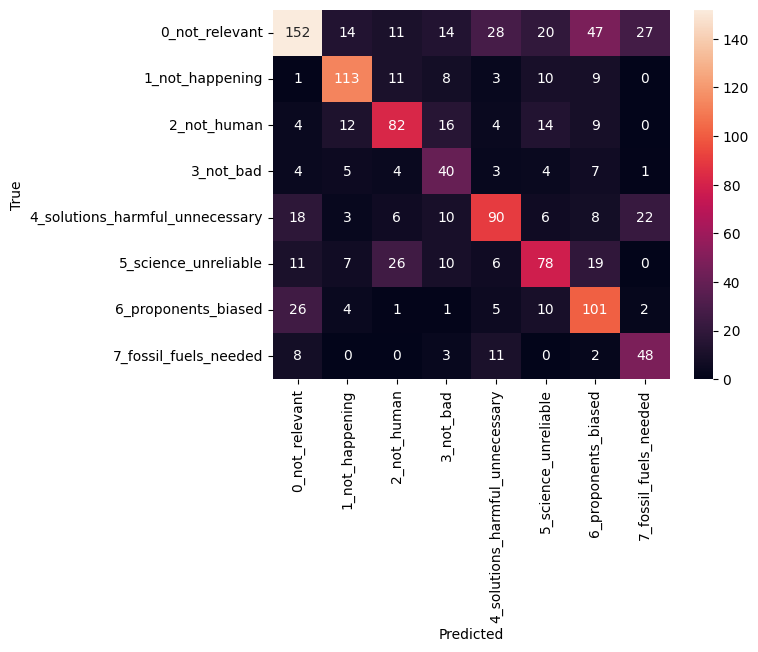

In [ ]:
names=np.unique(labels)
cm = confusion_matrix(labels, pred_labels, labels=names)
sns.heatmap(
    cm,
    annot=True,
    fmt='g',
    xticklabels=names,
    yticklabels=names)
plt.xlabel("Predicted")
plt.ylabel("True")

In [ ]:
print(classification_report(labels, pred_labels, target_names=names, digits=4))

                                 precision    recall  f1-score   support

                 0_not_relevant     0.6786    0.4856    0.5661       313
                1_not_happening     0.7152    0.7290    0.7220       155
                    2_not_human     0.5816    0.5816    0.5816       141
                      3_not_bad     0.3922    0.5882    0.4706        68
4_solutions_harmful_unnecessary     0.6000    0.5521    0.5751       163
           5_science_unreliable     0.5493    0.4968    0.5217       157
            6_proponents_biased     0.5000    0.6733    0.5739       150
          7_fossil_fuels_needed     0.4800    0.6667    0.5581        72

                       accuracy                         0.5775      1219
                      macro avg     0.5621    0.5967    0.5711      1219
                   weighted avg     0.5952    0.5775    0.5784      1219

